In this demo, we follow [Tyler Sloan](https://quorumetrix.blogspot.com/2018/06/visualizing-lidar-data-with-datashader.html)'s walkthrough where he downloads LiDAR data from the City of Montreal (featuring the 1976 Olympic Stadium) and visualize it ([original notebook here](https://github.com/tsloan1377/montreal_open_data/blob/master/lidar_datashader_blog.ipynb)).

This notebook depends on the LAStools for working with LiDAR - we only really need the LASzip tool, but we've installed the entire suite. You can see what other tools are available from the filemanager in the [LAStools/bin](Lastools/bin) directory.

## Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import imageio
from laspy.file import File
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib import cm

We use `curl` to get the `.laz`, the compressed lidar data from the city of Montreal which we save as mtl.lz

In [1]:
!curl http://depot.ville.montreal.qc.ca/geomatique/lidar_aerien/2015/300-5046_2015.laz > mtl.laz
    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.8M  100 67.8M    0     0  14.0M      0  0:00:04  0:00:04 --:--:-- 15.1M 0:00:04  0:00:01 12.9M


Now we need to make the LASzip file executable; you'll need to do this to the other tools individually if you wish to use any of the other tools in that bin, by the way.

In [6]:
!chmod 755 LAStools/bin/laszip

We unzip the lidar data, specifying the input and outputs:

In [9]:
!LAStools/bin/laszip -i mtl.laz -o mtl.las

## Load LIDAR file with LasPy

In [10]:
sample_data = 'mtl.las'
export_path = 'export//'

In [13]:
inFile = File(sample_data, mode='r')
df = pd.DataFrame() 
df['X'] = inFile.X 
df['Y'] = inFile.Y 
df['Z'] = inFile.Z
df['class'] = inFile.classification
display(df)

X       Y      Z  class
0          19680  998190  41630      1
1          18250  999920  41600      1
2          18390  999690  41570      2
3          18530  999460  41540      2
4          18690  999220  41580      2
5          18830  998990  41600      2
6          18980  998750  41620      1
7          19130  998510  41620      2
8          17870  999760  41600      2
9          18030  999500  41600      2
10         18170  999280  41600      1
11         18320  999030  41600      1
12         18460  998810  41610      1
13         18600  998590  41620      1
14         18900  998110  41610      2
15         19050  997880  41620      2
16         19200  997650  41610      2
17         19340  997410  41620      1
18         19770  996730  41620      2
19         17440  999740  41620      2
20         17590  999490  41630      1
21         17730  999280  41620      1
22         17880  999040  41590      1
23         18020  998820  41550      2
24         18170  998570  41580      2
25         18320  998330  41600      1
26         18470  998100  41590      2
27         18610  997870  41590      2
28         18760  997640  41600      1
29         18900  997420  41580      2
...          ...     ...    ...    ...
16803645  999370  121710  24190      2
16803646  999530  121440  24180      2
16803647  999680  121160  24180      2
16803648  999840  120870  24170      2
16803649  997900  124970  24170      2
16803650  999010  122970  24190      2
16803651  999180  122670  24200      1
16803652  999320  122400  24210      1
16803653  999480  122110  24200      1
16803654  999630  121850  24200      1
16803655  999800  121550  24200      1
16803656  999950  121260  24180      2
16803657  998150  125140  24150      2
16803658  998310  124860  24180      1
16803659  999260  123130  24180      2
16803660  999410  122870  24190      2
16803661  999560  122580  24180      1
16803662  999720  122300  24180      1
16803663  999890  121990  24190      1
16803664  998490  125390  24160      2
16803665  999610  123370  24280      1
16803666  999760  123090  24180      2
16803667  999920  122790  24190      1
16803668  999040  125260  24200      1
16803669  999730  124030  24530      1
16803670  999990  123540  24180      2
16803671  999290  125390  24090      2
16803672  999550  125560  24170      1
16803673  999710  125270  24130      2
16803674  999910  125790  24140      2

[16803675 rows x 4 columns]

## Plot the tile using datashader

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


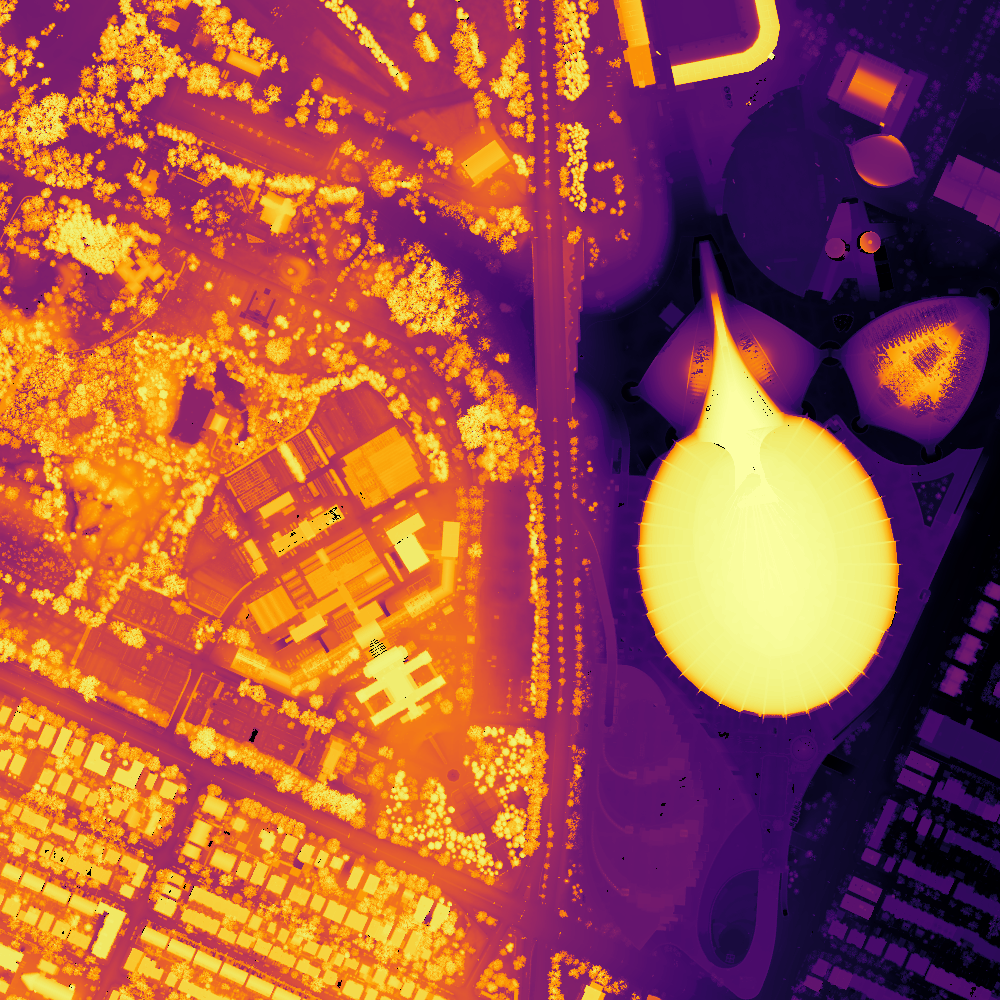

In [14]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(df, 'X', 'Y', ds.mean('Z'))
img = tf.shade(agg)#, cmap=['lightblue', 'darkblue'], how='log')
tf.set_background(tf.shade(agg, cmap=cm.inferno),"black")

## Separate the different classes of pixel

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


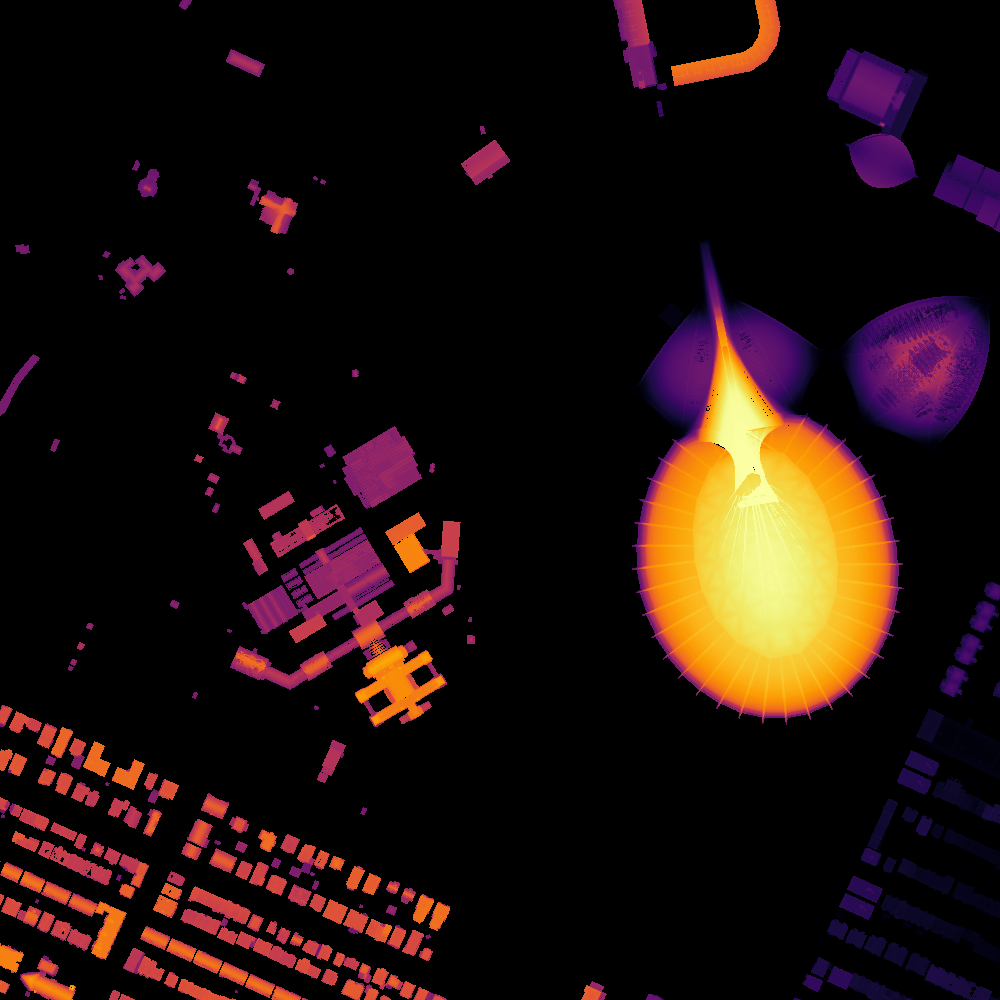

In [15]:
# Create a dataframe containing only the lidar voxels for buildings.
class_df = df.loc[df['class'] == 6]

# Visualize with datashader
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(class_df, 'X', 'Y', ds.mean('Z'))
img = tf.shade(agg)#, how='log')
tf.set_background(tf.shade(agg, cmap=cm.inferno),"black")

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


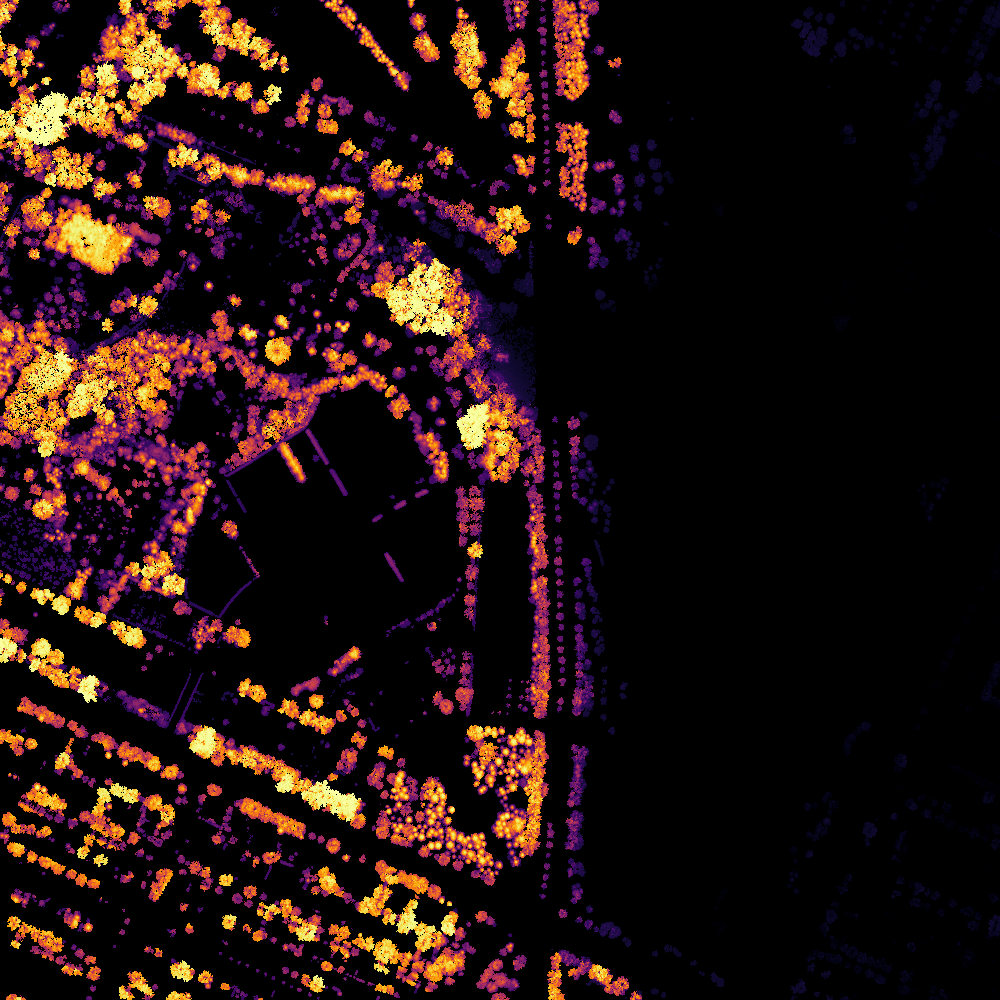

In [16]:
# Combine multiple classes of voxels that contain levels of vegetation
veg_df = df.loc[(df['class'] > 2) & (df['class'] < 6)]

# Visualize with datashader
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(veg_df, 'X', 'Y', ds.mean('Z'))
img = tf.shade(agg)#, how='log')
tf.set_background(tf.shade(agg, cmap=cm.inferno),"black")

## Create a 3D surface visualization

In [ ]:
# Use entire image containing olympic stadium, etc.
X = df['X']
Y = df['Y']
Z = df['Z']

# Downsample x and y
ds_factor = 500
ds_x = X[::ds_factor] 
ds_y = Y[::ds_factor] 
ds_z = Z[::ds_factor] 

##### Export the gif
frames = []
identifier = 'bigO_tile_downsample_' + str(ds_factor) + 'x_surface_lidar'  

if not os.path.exists(export_path):
    os.makedirs(export_path)

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(ds_x, ds_y, ds_z, cmap=cm.inferno,
                       linewidth=0, antialiased=False)

for angle in range(0, 360):
    ax.view_init(60, angle) # Higher angle than usually used of 30.
    ax.set_axis_off()

    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)

imageio.mimsave(export_path + identifier + '.gif', frames)

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
